# Hybrid Node Clustering Approach for Graph-Based Anti-Money Laundering



==============================================================================
### Import Dependencies
==============================================================================

In [ ]:
######################################################
# Additional Lib
######################################################
import datetime
import os
from typing import Callable, Optional
import pandas as pd
import json
import warnings
warnings.filterwarnings("ignore")
######################################################
# Data Visualizations
######################################################
import matplotlib.pyplot as plt
import matplotlib as matplot
import seaborn as sns

######################################################
# Data Preprocessing
######################################################
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
######################################################
# Modelling
######################################################
from sklearn import preprocessing
import numpy as np
#import torch
#import torch_geometric.transforms as T
#from torch_geometric.loader import NeighborLoader
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import xgboost as xgb
from sklearn.metrics import accuracy_score
import numpy as np
import gc
from tqdm.notebook import tqdm
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from datetime import datetime

######################################################
# PROJECT PATH 
######################################################
import sys
import os
from dotenv import load_dotenv
load_dotenv(override=True)
sys.path.append(os.getenv("PROJECT_PATH"))

==============================================================================
### LOADING DATA
==============================================================================

In [3]:
pd.set_option('display.max_columns', None)
path = './data/dataset.csv'
df = pd.read_csv(path)
df.head(10)
# df = df.head(500000)
df.head()

print("\n\n\n")
print("DATASET LENGTH")
print("ROWS: ", df.shape[0])
print("COLUMNS: ", df.shape[1])





DATASET LENGTH
ROWS:  5078345
COLUMNS:  11


In [4]:
###################################################################################################
# Data Visualization Function - Helpers
###################################################################################################

def format_title_output(text):
    return f"{'++' * 50}\n{text.upper()}\n{'++' * 50}\n"


#Null data with heatmap
def create_null_data_heatmap(
    title=None,
    rotate='horizontal',
    dataset=None
):
    try:
        plt.figure(figsize=(15,5))
        sns.heatmap(dataset.isnull(), cbar=False)
        plt.title(title, fontweight='bold')
        plt.xticks(rotation=rotate)
        plt.show()
    except Exception as error:
        print("**"*50)
        print("ERROR TO CREATE THE HEATMAP: ", error)
        print("**"*50)


#Null data with heatmap
def create_correlation_heatmap(
    title=None,
    dataset=None
):
    try:
        plt.figure(figsize=(15,8))
        correlation = dataset.corr()
        correlation = (correlation)
        sns.heatmap(correlation,
                    xticklabels=correlation.columns.values,
                    yticklabels=correlation.columns.values,
                    annot=True
        )
        plt.title(title, fontweight='bold')
        plt.show()
    except Exception as error:
        print("**"*50)
        print("ERROR TO CREATE THE HEATMAP: ", error)
        print("**"*50)

def create_boxplots(data, columns, ncols=2, figsize=(25, 6)):
    nrows = (len(columns) + ncols - 1) // ncols
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    axes = axes.flatten() if nrows > 1 else axes
    for i, col in enumerate(columns):
        sns.boxplot(y=data[col], ax=axes[i])
        axes[i].set_title(col)
    for j in range(len(columns), len(axes)):
        axes[j].axis('off')
    plt.tight_layout()
    plt.show()


def create_histogram(data, column, figsize=(15, 4), color="g", kde=False):
    try:
        plt.figure(figsize=figsize)
        sns.histplot(data[column], kde=kde, color=color).set_title(f'{column[0]} Distribution', fontweight='bold')
        plt.title(f"{column[0]} Distribution", fontweight='bold')
        plt.show()
    except Exception as error:
        print("**"*50)
        print("ERROR TO CREATE THE HISTOGRAM: ", error)
        print("**"*50)

###################################################################################################
# Data Preprocessing - Helpers
###################################################################################################
def detect_outliers(data, columns):
    outlier_info = {}
    for col in columns:
        Q1 = data[col].quantile(0.25)  # First quartile (25th percentile)
        Q3 = data[col].quantile(0.75)  # Third quartile (75th percentile)
        IQR = Q3 - Q1  # Interquartile range
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = data[(data[col] < lower_bound) | (data[col] > upper_bound)]
        max_outlier = outliers[col].max() if not outliers.empty else None

        outlier_info[col] = {
            "max_outlier_value": max_outlier,
            "number_of_outliers": outliers.shape[0],
            "lower_bound": lower_bound,
            "upper_bound": upper_bound,
        }

    return outlier_info

In [5]:
# Check the dataset info
print(format_title_output("DATASET INFO"))
print(df.info())

print("\n\n\n")
print(format_title_output("DATASET LENGTH"))
print("ROWS: ", df.shape[0])
print("COLUMNS: ", df.shape[1])

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
DATASET INFO
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5078345 entries, 0 to 5078344
Data columns (total 11 columns):
 #   Column              Dtype  
---  ------              -----  
 0   Timestamp           object 
 1   From Bank           int64  
 2   Account             object 
 3   To Bank             int64  
 4   Account.1           object 
 5   Amount Received     float64
 6   Receiving Currency  object 
 7   Amount Paid         float64
 8   Payment Currency    object 
 9   Payment Format      object 
 10  Is Laundering       int64  
dtypes: float64(2), int64(3), object(6)
memory usage: 426.2+ MB
None




++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
DATASET LENGTH
+++++++++++++++++++++++++++++++++++++++++++++++++++++

In [6]:
# rename the columns with lowercase and _ underscore if there is a space
print(format_title_output("DATASET NEW COLUMNS"))

df.columns = [col.lower().replace(" ", "_") for col in df.columns]
for i,j in enumerate(df.columns):
    print(i, " : ", j)

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
DATASET NEW COLUMNS
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

0  :  timestamp
1  :  from_bank
2  :  account
3  :  to_bank
4  :  account.1
5  :  amount_received
6  :  receiving_currency
7  :  amount_paid
8  :  payment_currency
9  :  payment_format
10  :  is_laundering


In [7]:
# Convert the timestamp column to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Get the min and max datetime
min_time = df['timestamp'].min()
max_time = df['timestamp'].max()

print("Min Datetime:", min_time)
print("Max Datetime:", max_time)

Min Datetime: 2022-09-01 00:00:00
Max Datetime: 2022-09-18 16:18:00


In [8]:
amount_consistency = df.loc[~(df['amount_received'] == df['amount_paid'])]
ccy_consistency = df.loc[~(df['receiving_currency'] == df['payment_currency'])]

print(format_title_output("AMOUNT CONSISTENCY - CREDIT & DEBIT"))
print(amount_consistency.shape)

print(format_title_output("CURRENCY CONSISTENCY - CREDIT & DEBIT"))
print(ccy_consistency.shape)

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
AMOUNT CONSISTENCY - CREDIT & DEBIT
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

(72158, 11)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
CURRENCY CONSISTENCY - CREDIT & DEBIT
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

(72170, 11)


In [9]:
#Check the currency

print(format_title_output("RECEIVED CURRENCY"))
print(df['receiving_currency'].unique())
print("\n\n")

print(format_title_output("PAYMENT CURRENCY"))
print(df['payment_currency'].unique())

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
RECEIVED CURRENCY
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++



['US Dollar' 'Bitcoin' 'Euro' 'Australian Dollar' 'Yuan' 'Rupee'
 'Mexican Peso' 'Yen' 'UK Pound' 'Ruble' 'Canadian Dollar' 'Swiss Franc'
 'Brazil Real' 'Saudi Riyal' 'Shekel']



++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
PAYMENT CURRENCY
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

['US Dollar' 'Bitcoin' 'Euro' 'Australian Dollar' 'Yuan' 'Rupee' 'Yen'
 'Mexican Peso' 'UK Pound' 'Ruble' 'Canadian Dollar' 'Swiss Franc'
 'Brazil Real' 'Saudi Riyal' 'Shekel']


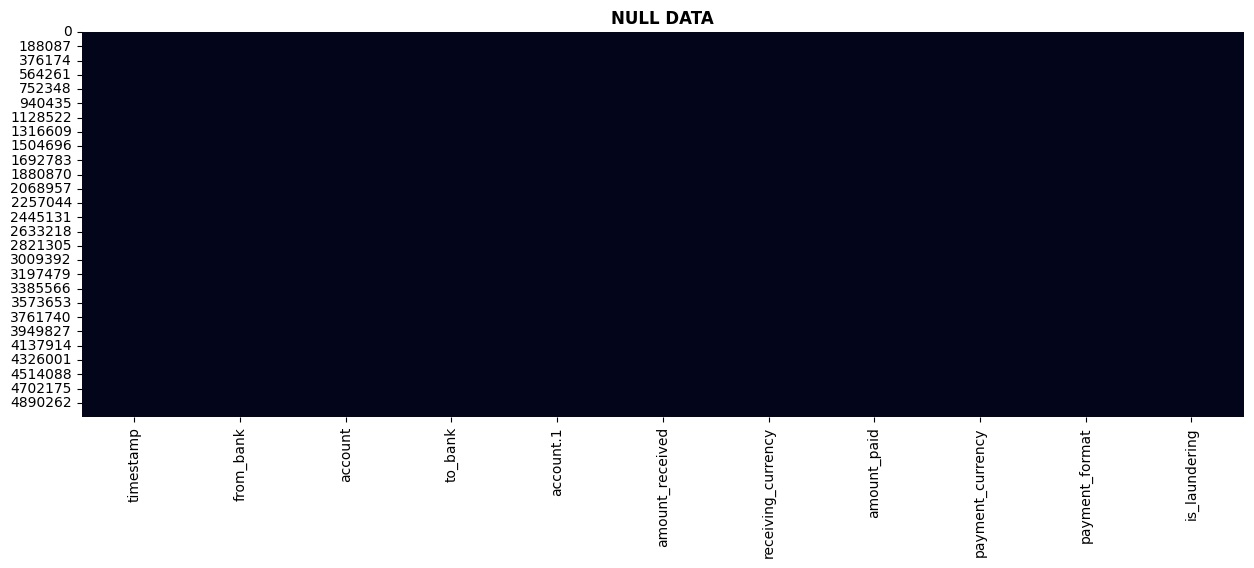

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
NULL DATA NUMBER
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

timestamp             0
from_bank             0
account               0
to_bank               0
account.1             0
amount_received       0
receiving_currency    0
amount_paid           0
payment_currency      0
payment_format        0
is_laundering         0
dtype: int64


In [10]:
create_null_data_heatmap("NULL DATA", 'vertical', df)
print(format_title_output("NULL DATA NUMBER"))
print(df.isnull().sum())

In [11]:
negative_df = df[df['amount_paid'] < 0]
negative_df

,timestamp,from_bank,account,to_bank,account.1,amount_received,receiving_currency,amount_paid,payment_currency,payment_format,is_laundering


In [12]:
df.head()
print(df.describe(include='all'))

                            timestamp     from_bank    account       to_bank  \
count                         5078345  5.078345e+06    5078345  5.078345e+06   
unique                            NaN           NaN     496995           NaN   
top                               NaN           NaN  100428660           NaN   
freq                              NaN           NaN     168672           NaN   
mean    2022-09-05 07:16:08.194274816  4.573057e+04        NaN  6.574456e+04   
min               2022-09-01 00:00:00  1.000000e+00        NaN  1.000000e+00   
25%               2022-09-02 04:32:00  1.190000e+02        NaN  4.259000e+03   
50%               2022-09-05 12:16:00  9.679000e+03        NaN  2.156800e+04   
75%               2022-09-08 03:13:00  2.862800e+04        NaN  1.223320e+05   
max               2022-09-18 16:18:00  3.563030e+05        NaN  3.562940e+05   
std                               NaN  8.176562e+04        NaN  8.409299e+04   

        account.1  amount_received rece

In [13]:
# Check the outlier for the amount of each transaction
# Function to convert to USD
# from forex_python.converter import CurrencyRates
exchange_rates = {
    'Australian Dollar': 0.62124,  # AUD
    'Bitcoin': 23000.0,            # BTC (example rate)
    'Brazil Real': 0.1980,         # BRL
    'Canadian Dollar': 0.6876,     # CAD
    'Euro': 1.0362,                # EUR
    'Mexican Peso': 0.04835,       # MXN
    'Ruble': 0.01636,              # RUB
    'Rupee': 0.01153,              # INR
    'Saudi Riyal': 0.2667,         # SAR
    'Shekel': 0.2840,              # ILS
    'Swiss Franc': 1.0989,         # CHF
    'UK Pound': 1.2401,            # GBP
    'US Dollar': 1.0,              # USD
    'Yen': 0.006443,               # JPY
    'Yuan': 0.1391                 # CNY
}

# Function to convert to USD
def convert_to_usd(currency, amount):
    if currency in exchange_rates:
        return amount * exchange_rates[currency]
    else:
        print(f"Exchange rate for {currency} not found.")
        return amount

def create_bar_plot(df, column_name, title=None):
    plt.figure(figsize=(20, 5))
    sns.countplot(x=column_name, data=df, order=df[column_name].value_counts().index, palette='Set2')
    plt.title(title, fontweight='bold', color='#065164')
    plt.show()
    print(format_title_output(title.upper() + " VALUE COUNTS"))
    print(df[column_name].value_counts())

def create_pie_plot(df, column_name, title=None):
    plt.figure(figsize=(8, 8))
    df[column_name].value_counts().plot.pie(autopct='%1.1f%%', colors=sns.color_palette('Set2', len(df[column_name].value_counts())))
    plt.title(title, fontweight='bold', color='#065164')
    plt.show()
    print(format_title_output(title.upper() + " VALUE COUNTS"))
    print(df[column_name].value_counts())

def create_kde_plot(df, column_name, title=None, color='g'):
    plt.figure(figsize=(15, 5))
    sns.kdeplot(df[column_name], shade=True, color=color)
    plt.title(title, fontweight='bold', color='#065164')
    plt.show()

def create_kde_plot_with_log(df, column_name, title=None, color='r'):
    log_column = np.log1p(df[column_name])  # log(x+1) to avoid issues with zero values
    plt.figure(figsize=(15, 5))
    sns.kdeplot(log_column, shade=True, color=color)
    plt.title(title, fontweight='bold', color='#065164')
    plt.show()
    print(format_title_output(title.upper()))
    print(log_column.describe())

def create_histogram_with_bins(df, column_name, title=None, color='r', bins=20):
    plt.figure(figsize=(15, 5))
    sns.histplot(df[column_name], bins=bins, kde=True, color=color)
    plt.title(title, fontweight='bold', color='#065164')
    plt.show()

    print(format_title_output(title.upper()))
    print(df[column_name].describe())

def create_transaction_line_plot(df, date_column, amount_column, title=None):
    df[date_column] = pd.to_datetime(df[date_column])
    daily_transactions = df.groupby(df[date_column].dt.date)[amount_column].sum().reset_index()
    plt.figure(figsize=(15, 5))
    sns.lineplot(x=daily_transactions[date_column], y=daily_transactions[amount_column],
                 marker='o', color='b', linewidth=2, markersize=8, label='Transaction Amount')
    plt.title(title, fontweight='bold', color='#065164', fontsize=12)
    plt.xlabel('Date', fontsize=12, color='#065164')
    plt.ylabel('Total Transaction Amount', fontweight='bold', fontsize=12, color='#065164')
    plt.show()


In [14]:
# Convert to the USD currency based on the exchange rate
df['usd_amount'] = df.apply(lambda row: convert_to_usd(row['payment_currency'], row['amount_paid']), axis=1)
none_us_dollar = df.loc[(df['payment_currency'] != 'US Dollar')]
none_us_dollar.head()

,timestamp,from_bank,account,to_bank,account.1,amount_received,receiving_currency,amount_paid,payment_currency,payment_format,is_laundering,usd_amount
1155,2022-09-01 00:16:00,220,8001C8C51,1420,8003093C1,0.025852,Bitcoin,0.025852,Bitcoin,Bitcoin,0,594.596000
1174,2022-09-01 00:22:00,1362,80030A870,11,80064C9B0,52.110000,Euro,52.110000,Euro,Credit Card,0,53.996382
1467,2022-09-01 00:15:00,1,80005C0A1,1588,8003AC471,0.016891,Bitcoin,0.016891,Bitcoin,Bitcoin,0,388.493000
3940,2022-09-01 00:08:00,513,8006538E1,1688,8006DD361,1.621978,Bitcoin,1.621978,Bitcoin,Bitcoin,0,37305.494000
6302,2022-09-01 00:19:00,1688,800646381,1674,800B1B1B1,0.045449,Bitcoin,0.045449,Bitcoin,Bitcoin,0,1045.327000


# Data Preprocessing and Training

In [15]:
def remove_label_from_dataframe(df):
    """
    Load and preprocess transaction data for anomaly detection
    """
    if 'is_laundering' in df.columns:
        df = df.drop('is_laundering', axis=1)
    return df

def extract_time_features(df):
    """
    Extract useful time-based features from the timestamp column
    """
    if df['timestamp'].dtype == 'object':
        df['timestamp'] = pd.to_datetime(df['timestamp'])

    df['hour_of_day'] = df['timestamp'].dt.hour
    df['day_of_week'] = df['timestamp'].dt.dayofweek
    df['day_of_month'] = df['timestamp'].dt.day
    df['month'] = df['timestamp'].dt.month
    df['is_weekend'] = df['timestamp'].dt.dayofweek >= 5
    df = df.drop('timestamp', axis=1)

    return df

def build_preprocessing_pipeline(df):
    """
    Build a preprocessing pipeline for the dataset
    """
    numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
    categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

    if 'timestamp' in numeric_cols:
        numeric_cols.remove('timestamp')

    numeric_transformer = StandardScaler()
    categorical_transformer = OneHotEncoder(handle_unknown='ignore')
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_cols),
            ('cat', categorical_transformer, categorical_cols)
        ])

    return preprocessor

def build_and_train_isolation_forest(df, contamination=0.05):
    """
    Build and train an Isolation Forest model
    contamination: expected proportion of outliers in the dataset
    """
    # Extract time features
    df = extract_time_features(df)
    preprocessor = build_preprocessing_pipeline(df)

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('isolation_forest', IsolationForest(
            contamination=contamination,
            random_state=42,
            n_estimators=100,
            max_samples='auto',
            max_features=1.0
        ))
    ])

    pipeline.fit(df)
    return pipeline, df

def detect_anomalies(pipeline, df, original_df=None):
    """
    Detect anomalies in the dataset using the trained Isolation Forest model
    """
    anomaly_scores = pipeline.named_steps['isolation_forest'].decision_function(
        pipeline.named_steps['preprocessor'].transform(df)
    )

    anomaly_predictions = pipeline.named_steps['isolation_forest'].predict(
        pipeline.named_steps['preprocessor'].transform(df)
    )

    # Convert anomaly predictions to boolean (True for anomaly, False for normal)
    is_anomaly = anomaly_predictions == -1

    # Create a DataFrame with the results
    if original_df is None:
        original_df = df.copy()

    results = original_df.copy()
    results['anomaly_score'] = anomaly_scores
    results['is_anomaly'] = is_anomaly

    # Add is_laundering back for evaluation if it was in the original data
    if 'is_laundering' in original_df.columns:
        results['is_laundering'] = original_df['is_laundering']

    return results

# Function to analyze and visualize results
def analyze_results(results):
    """
    Analyze and visualize the anomaly detection results
    """
    # Count normal vs anomaly predictions
    anomaly_counts = results['is_anomaly'].value_counts()
    print(f"Normal transactions: {anomaly_counts.get(False, 0)}")
    print(f"Anomalous transactions: {anomaly_counts.get(True, 0)}")

    # If we have the actual labels, compare predictions with true labels
    if 'is_laundering' in results.columns:
        confusion_matrix = pd.crosstab(
            results['is_anomaly'],
            results['is_laundering'],
            rownames=['Predicted Anomaly'],
            colnames=['Actual Laundering']
        )
        print("\nConfusion Matrix:")
        print(confusion_matrix)

        # Calculate precision, recall, and F1 score if possible
        true_positives = confusion_matrix.loc[True, True] if True in confusion_matrix.index and True in confusion_matrix.columns else 0
        false_positives = confusion_matrix.loc[True, False] if True in confusion_matrix.index and False in confusion_matrix.columns else 0
        false_negatives = confusion_matrix.loc[False, True] if False in confusion_matrix.index and True in confusion_matrix.columns else 0

        if true_positives + false_positives > 0:
            precision = true_positives / (true_positives + false_positives)
            print(f"Precision: {precision:.4f}")

        if true_positives + false_negatives > 0:
            recall = true_positives / (true_positives + false_negatives)
            print(f"Recall: {recall:.4f}")

        if precision + recall > 0:
            f1_score = 2 * precision * recall / (precision + recall)
            print(f"F1 Score: {f1_score:.4f}")

    # Visualize anomaly scores distribution
    plt.figure(figsize=(15, 8))
    sns.histplot(results['anomaly_score'], bins=50, kde=True)
    plt.axvline(x=0, color='red', linestyle='--')
    plt.title('Distribution of Anomaly Scores')
    plt.xlabel('Anomaly Score')
    plt.ylabel('Frequency')
    plt.show()

    # Visualize relationship between key features and anomaly status
    numeric_features = ['amount_received', 'amount_paid', 'usd_amount']
    for feature in numeric_features:
        if feature in results.columns:
            plt.figure(figsize=(15, 8))
            sns.boxplot(x='is_anomaly', y=feature, data=results)
            plt.title(f'Relationship Between {feature} and Anomaly Status')
            plt.show()

    # Return most anomalous transactions
    return results.sort_values('anomaly_score').head(20)

In [16]:
original_data = df.copy().head(100000)
print(original_data.columns)
print("label distribution: ", original_data.is_laundering.value_counts())

Index(['timestamp', 'from_bank', 'account', 'to_bank', 'account.1',
       'amount_received', 'receiving_currency', 'amount_paid',
       'payment_currency', 'payment_format', 'is_laundering', 'usd_amount'],
      dtype='object')
label distribution:  is_laundering
0    99995
1        5
Name: count, dtype: int64


In [ ]:
from services.memgraph import MemgraphClient
mg_client = MemgraphClient()

query = "MATCH (a:Account) RETURN a.account_id, a.bank LIMIT 10"
results = mg_client.execute_query(query)

if results:
    for row in results:
        print(row)

✅ Connected to Memgraph at 192.168.205.140:7687
{'a.account_id': '100428660', 'a.bank': '70'}
{'a.account_id': '800825340', 'a.bank': '1124'}
{'a.account_id': '805B716C0', 'a.bank': '11474'}
{'a.account_id': '80B39E7B0', 'a.bank': '15980'}
{'a.account_id': '80DC756E0', 'a.bank': '113798'}
{'a.account_id': '80E480620', 'a.bank': '32375'}
{'a.account_id': '812EE86F0', 'a.bank': '231004'}
{'a.account_id': '812EE89C0', 'a.bank': '21940'}
{'a.account_id': '8140702D0', 'a.bank': '152980'}
{'a.account_id': '1004286A8', 'a.bank': '70'}


Normal transactions: 99992
Anomalous transactions: 8


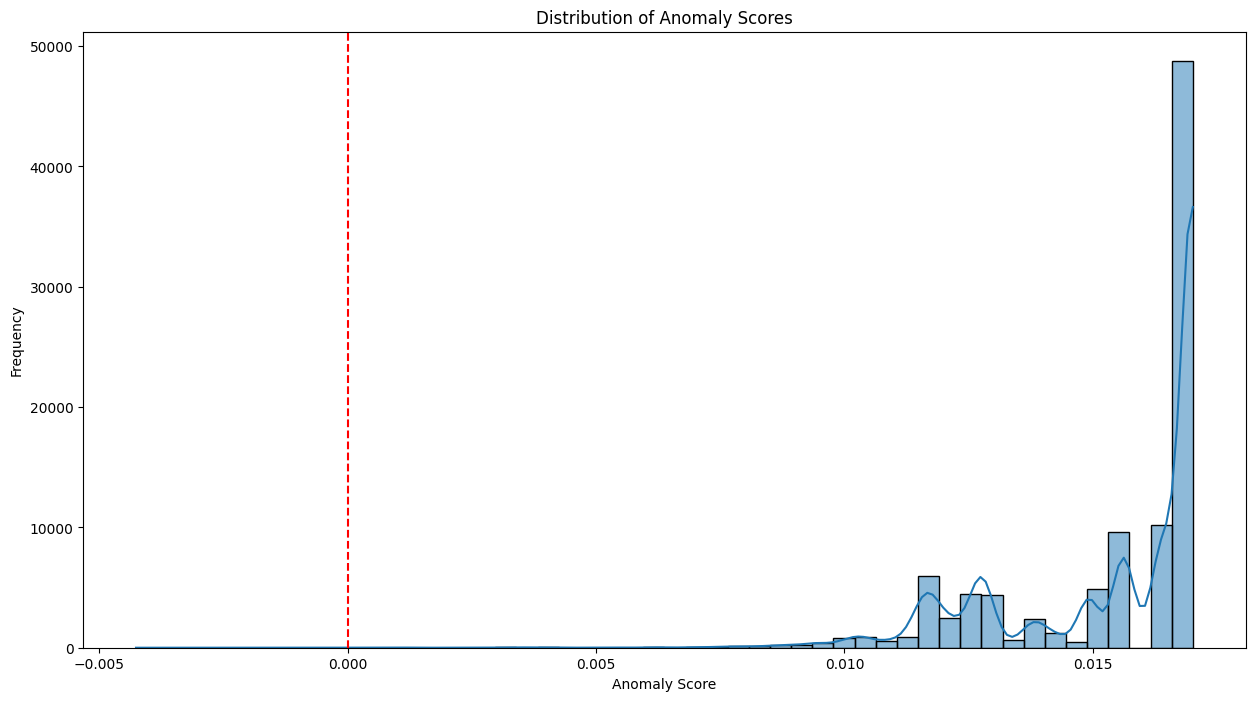

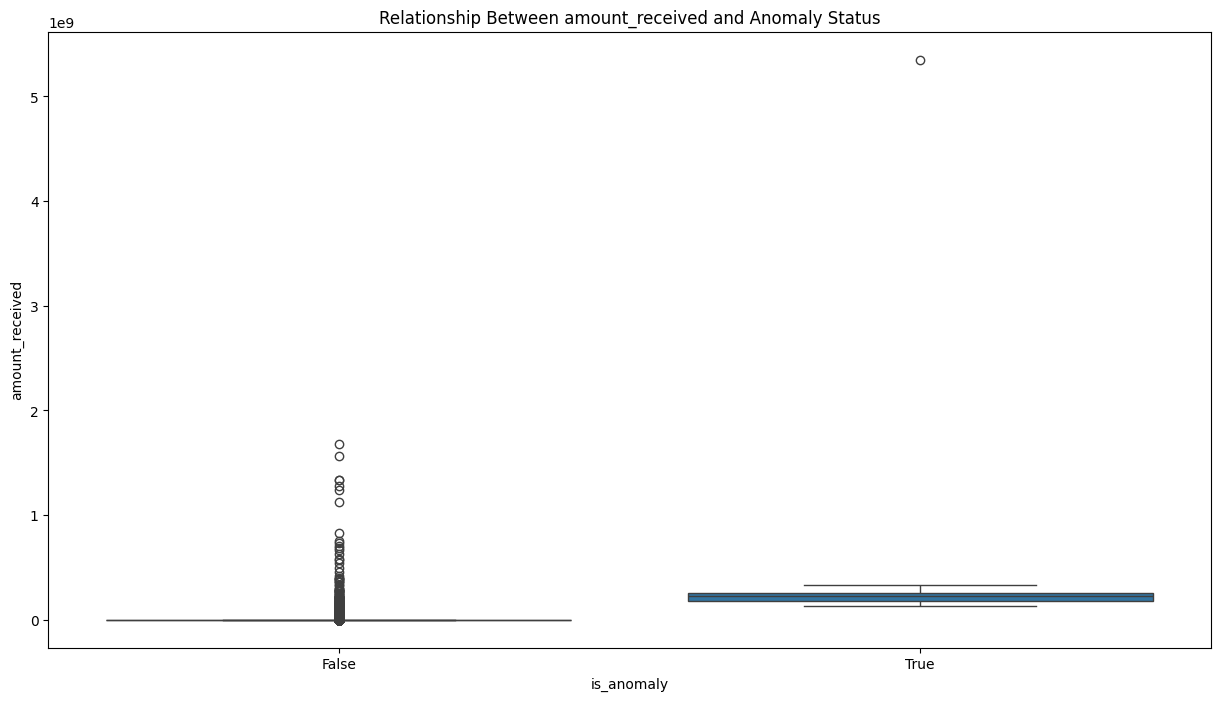

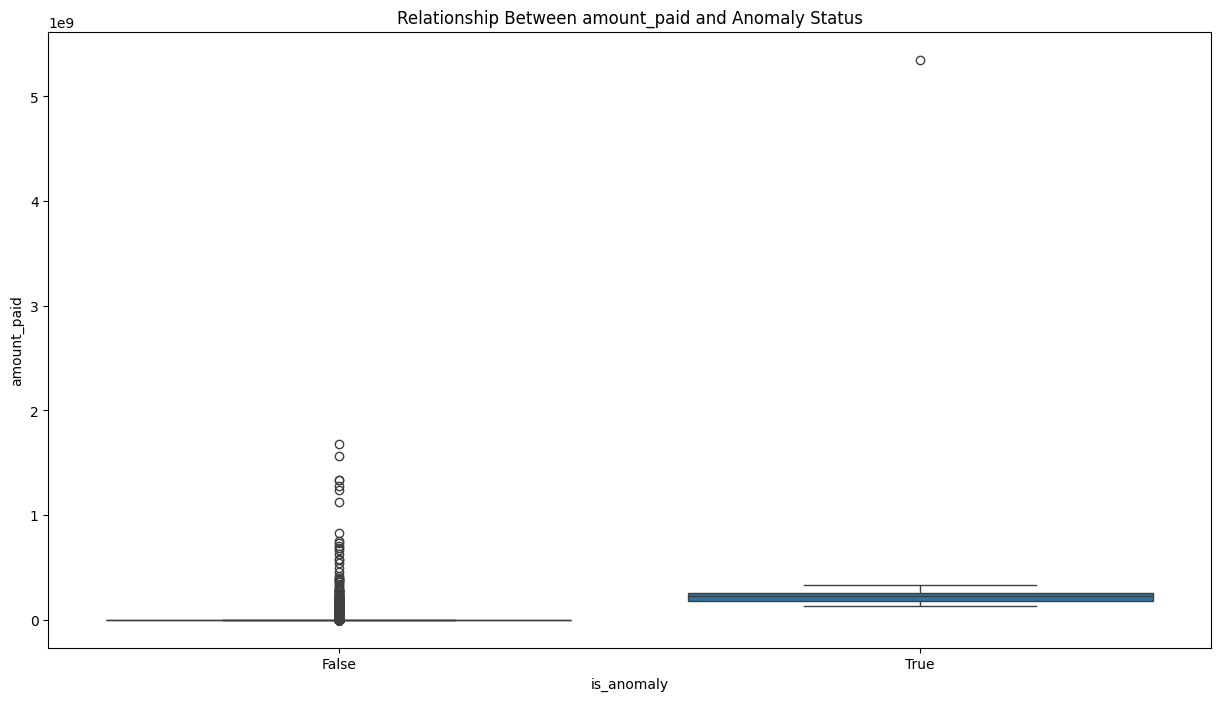

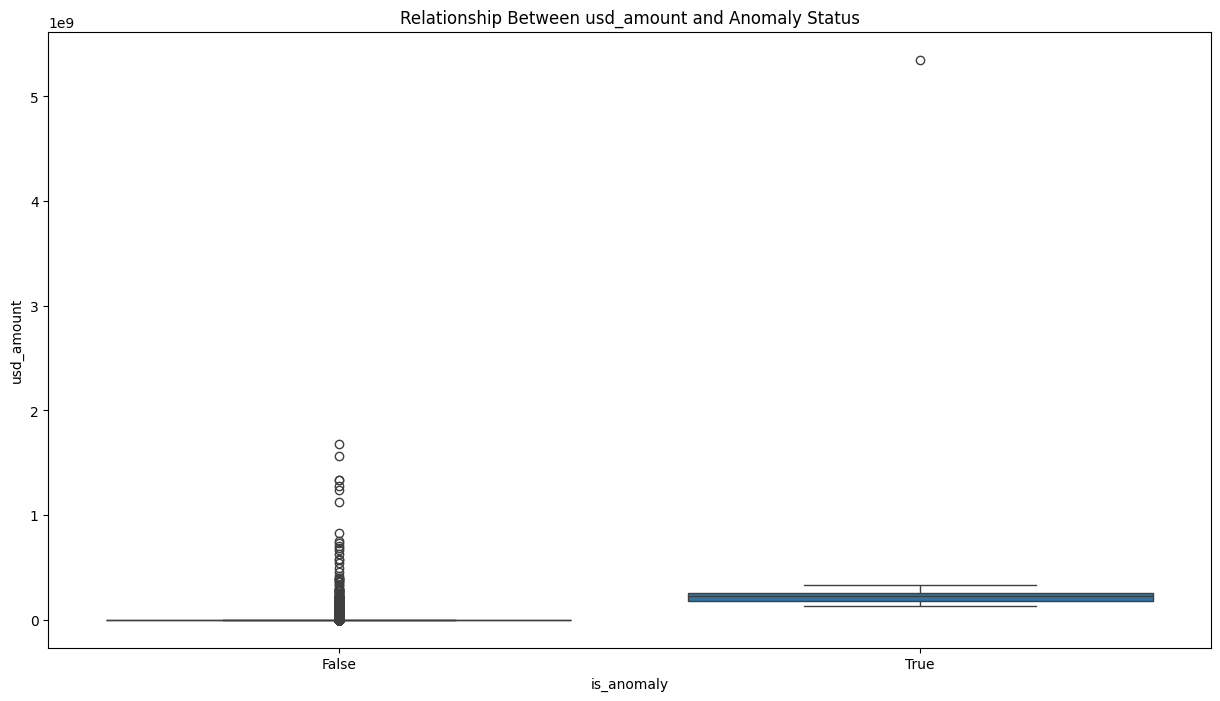


Most Anomalous Transactions:
                timestamp  from_bank  to_bank  amount_received    usd_amount  \
80060 2022-09-01 00:27:00         70   231786     1.792599e+08  1.792599e+08   
63654 2022-09-01 00:24:00         70    16031     1.777817e+08  1.777817e+08   
7194  2022-09-01 00:10:00         70     1457     2.233573e+08  2.233573e+08   
5746  2022-09-01 00:14:00       2843     1688     2.201032e+08  2.201032e+08   
83347 2022-09-01 00:18:00         12   132921     3.318110e+08  3.318110e+08   
75790 2022-09-01 00:19:00       1588   117299     2.277032e+08  2.277032e+08   
96109 2022-09-01 00:26:00         70   111443     1.258983e+08  1.258983e+08   
79141 2022-09-01 00:10:00     111443    28255     5.351189e+09  5.351189e+09   
59121 2022-09-01 00:26:00     120766   215841     3.905308e+08  3.905308e+08   
72777 2022-09-01 00:01:00      11157   130637     1.541505e+08  1.541505e+08   
34001 2022-09-01 00:18:00       1674   211075     2.126982e+08  2.126982e+08   
91584 2022

In [ ]:
#Adjust the contamination base on the is_laundering / none is_laundering

contamination=0.0001
# Copy the new dataframe and processing
df = remove_label_from_dataframe(original_data)
pipeline, processed_df = build_and_train_isolation_forest(df, contamination)
results = detect_anomalies(pipeline, processed_df, df)
most_anomalous = analyze_results(results)

print("\nMost Anomalous Transactions:")
print(most_anomalous[['timestamp', 'from_bank', 'to_bank', 'amount_received', 'usd_amount', 'anomaly_score']])

print(pipeline)
print(results)

In [ ]:
print(original_data[original_data['is_laundering'] == 1])

                timestamp  from_bank    account  to_bank  account.1  \
4742  2022-09-01 00:21:00         70  100428660     1124  800825340   
40621 2022-09-01 00:03:00         70  100428660    11474  805B716C0   
69152 2022-09-01 00:01:00         70  100428660    15980  80B39E7B0   
85763 2022-09-01 00:03:00         70  100428660   113798  80DC756E0   
90684 2022-09-01 00:23:00         70  100428660    32375  80E480620   

       amount_received receiving_currency  amount_paid payment_currency  \
4742         389769.39          US Dollar    389769.39        US Dollar   
40621         29024.33          US Dollar     29024.33        US Dollar   
69152           792.92          US Dollar       792.92        US Dollar   
85763      13171425.53          US Dollar  13171425.53        US Dollar   
90684         14288.83          US Dollar     14288.83        US Dollar   

      payment_format  is_laundering   usd_amount  
4742          Cheque              1    389769.39  
40621    Credit Card

In [ ]:
print(results[results['is_anomaly'] == 1])

                timestamp  from_bank    account  to_bank  account.1  \
5746  2022-09-01 00:14:00       2843  800647440     1688  800A506C0   
7194  2022-09-01 00:10:00         70  100428660     1457  800C60510   
63654 2022-09-01 00:24:00         70  100428660    16031  80A0CA3D0   
75790 2022-09-01 00:19:00       1588  805EB2490   117299  80C327190   
79141 2022-09-01 00:10:00     111443  806A0E720    28255  80CF5FE00   
80060 2022-09-01 00:27:00         70  100428660   231786  80D10A880   
83347 2022-09-01 00:18:00         12  8006B5B50   132921  80D5EC840   
96109 2022-09-01 00:26:00         70  100428660   111443  80FD8F600   

       amount_received receiving_currency   amount_paid payment_currency  \
5746      2.201032e+08          US Dollar  2.201032e+08        US Dollar   
7194      2.233573e+08          US Dollar  2.233573e+08        US Dollar   
63654     1.777817e+08          US Dollar  1.777817e+08        US Dollar   
75790     2.277032e+08          US Dollar  2.277032e+08 